# Clasificación Automática de Imágenes de Mascotas con Redes Neuronales

## Introducción
Bienvenidos a este tutorial interactivo donde exploraremos el fascinante mundo del Deep Learning para realizar una tarea desafiante y emocionante: clasificar automáticamente imágenes de mascotas en categorías de perros y gatos. Utilizaremos para ello las avanzadas redes neuronales convolucionales, verdaderas protagonistas de la revolución en el aprendizaje profundo.

## Preparación de Datos: Eficiencia y Organización

Primero, separamos las imágenes en categorías de perros y gatos, utilizando anotaciones específicas para distribuirlas en conjuntos de entrenamiento y prueba. Este proceso se automatiza mediante un script que lee, clasifica y reubica las imágenes según corresponda, garantizando una estructura de datos coherente y fácil de navegar.

Con los datos ya organizados, empleamos `ImageDataGenerator` de TensorFlow para cargar y transformar estas imágenes en formatos que nuestro modelo pueda procesar eficientemente. Este paso no solo optimiza la carga de datos, reduciendo la memoria requerida, sino que también facilita la manipulación de imágenes durante el entrenamiento y la evaluación, permitiéndonos visualizar ejemplos y asegurar que el flujo de datos esté correctamente configurado.

In [4]:
import os

# Nombre de los directorios de las imágenes y las anotaciones
images_path = "images"
annotations_path = "annotations"

# Se leen todos los elementos de los archivos trainval.txt y test.txt
# Estos nos indican los archivos que están destinados para el entrenamiento y 
# cuales son destinados para validación

trainval = open(os.path.join(annotations_path, "trainval.txt")).readlines()
test = open(os.path.join(annotations_path, "test.txt")).readlines()

# Creamos las carpetas \train\ y \test\ y dentro de estas "cats" y "dogs" 
os.makedirs(os.path.join(images_path, "train", "cats"), exist_ok=True)
os.makedirs(os.path.join(images_path, "train", "dogs"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "cats"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "dogs"), exist_ok=True)

# Definición de la función que va a clasificar las imagenes, mas abajo se 
# llamará en bucle a esta funcion para ir moviendo las imágenes en las carpetas
# que hemos creado anteriormente
def classify_image(line, subset):
    basename = line.split(" ")[0]
    species = line.split(" ")[2]
    subfolder = "cats" if species == "1" else "dogs"
    oldpath = os.path.join(images_path, f"{basename}.jpg")
    newpath = os.path.join(images_path, subset, subfolder, f"{basename}.jpg")
    if os.path.isfile(oldpath):
        os.rename(oldpath, newpath)

for line in trainval:
    classify_image(line, "train")

for line in test:
    classify_image(line, "test")

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generador_entrenamiento = ImageDataGenerator()
datos_entrenamiento = generador_entrenamiento.flow_from_directory("images/train")
generador_test = ImageDataGenerator()
datos_test = generador_test.flow_from_directory("images/test", class_mode=None)
algunas_imagenes = next(datos_test)

2024-02-18 16:08:58.155018: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 3680 images belonging to 2 classes.
Found 3669 images belonging to 2 classes.


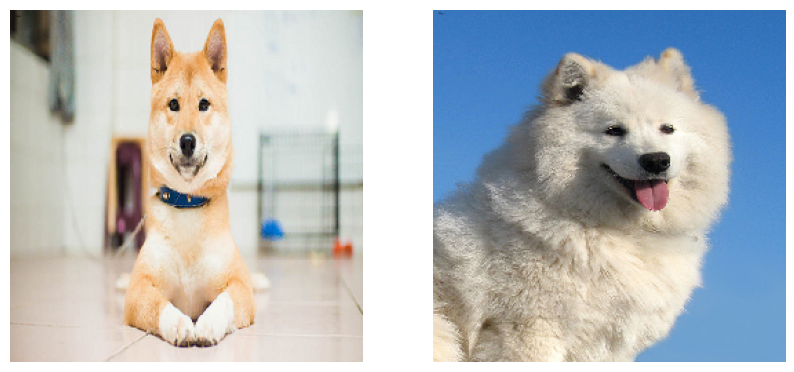

In [6]:
from matplotlib import pyplot as plt

# Ajusta el tamaño de la figura (ancho, alto) en pulgadas
plt.figure(figsize=(10, 5))

# Primer imagen en la primera columna
plt.subplot(1, 2, 1)
plt.imshow(algunas_imagenes[0] / 255.)
plt.axis('off') # Oculta los ejes

# Segunda imagen en la segunda columna
plt.subplot(1, 2, 2)
plt.imshow(algunas_imagenes[1] / 255.)
plt.axis('off')

plt.show()


## Implementación del Modelo

Para la clasificación de imágenes, implementamos el modelo **InceptionV3**, una red neuronal convolucional avanzada proporcionada por **TensorFlow**. Este modelo, preentrenado en el conjunto de datos **ImageNet**, se adapta para nuestro uso excluyendo la **capa superior** y ajustando el tamaño de entrada a imágenes de **256x256 píxeles**. Este enfoque nos permite aprovechar el **aprendizaje por transferencia**, utilizando conocimientos previamente adquiridos para identificar eficazmente características complejas en imágenes de perros y gatos, acelerando significativamente el proceso de entrenamiento y mejorando la precisión de nuestra clasificación desde el inicio.

In [7]:
from tensorflow.keras import applications
inception = applications.InceptionV3(include_top=False, input_shape=(256, 256, 3))

2024-02-18 16:10:14.951195: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Ajustes del Modelo

Tras integrar **InceptionV3** como base de nuestro modelo, procedemos a su personalización añadiendo **capas adicionales** para adaptarlo específicamente a nuestra tarea de clasificación entre perros y gatos. Utilizamos la API **Sequential** de **TensorFlow** para apilar un **Flatten** que convierte las características en un vector, seguido de dos capas **Dense**. La primera, con **128 unidades** y función de activación **"relu"**, sirve para añadir complejidad y capacidad de aprendizaje, mientras que la segunda, con **2 unidades** y función de activación **"softmax"**, nos permite obtener probabilidades de pertenencia a las categorías de perro o gato.

Este modelo personalizado se compila con el optimizador **"adam"** y la función de pérdida **"categorical_crossentropy"**, configuración óptima para tareas de clasificación categórica. Este paso final en la personalización del modelo asegura que esté listo para entrenarse con nuestro conjunto de datos específico, marcando el equilibrio entre la sofisticación de **InceptionV3** y nuestra adaptación para la clasificación precisa de mascotas.

In [8]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
predictor = Sequential([
    Flatten(), 
    Dense(128, activation="relu"), 
    Dense(2, activation="softmax")
])
modelo = Sequential([inception, predictor])
modelo.compile(optimizer="adam", loss="categorical_crossentropy")

## Entrenamiento

Con nuestro modelo ahora completamente personalizado, avanzamos hacia el **entrenamiento**. Este proceso se realiza llamando al método `.fit` sobre nuestro modelo, alimentándolo con los **datos de entrenamiento** preparados previamente. Configuramos el entrenamiento para que se ejecute durante **50 épocas**, lo que significa que el conjunto completo de datos pasará a través del modelo 50 veces. Este número de épocas se elige con la intención de permitir suficiente tiempo para que el modelo ajuste sus parámetros internos y aprenda a distinguir entre perros y gatos con la mayor precisión posible, optimizando el rendimiento general en esta tarea de clasificación.

In [9]:
modelo.fit(datos_entrenamiento, epochs=50)

Epoch 1/50


2024-02-18 16:12:41.471371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


115/115 [==============================] - 2156s 19s/step - loss: 0.5814
Epoch 2/50
115/115 [==============================] - 1929s 17s/step - loss: 0.0933
Epoch 3/50
115/115 [==============================] - 1586s 14s/step - loss: 0.7546
Epoch 4/50
115/115 [==============================] - 1574s 14s/step - loss: 0.6356
Epoch 5/50
115/115 [==============================] - 1582s 14s/step - loss: 0.6331
Epoch 6/50
115/115 [==============================] - 1580s 14s/step - loss: 0.6319
Epoch 7/50
115/115 [==============================] - 1582s 14s/step - loss: 0.6261
Epoch 8/50
115/115 [==============================] - 1580s 14s/step - loss: 0.6115
Epoch 9/50
115/115 [==============================] - 1579s 14s/step - loss: 0.5716
Epoch 10/50
115/115 [==============================] - 1585s 14s/step - loss: 0.4785
Epoch 11/50
115/115 [==============================] - 1686s 15s/step - loss: 0.3792
Epoch 12/50
115/115 [==============================] - 1585s 14s/step - loss: 0.2880


## Evaluación y Predicción

Iniciamos extrayendo un **lote de prueba** de nuestros datos preparados, que el modelo no ha visto durante su entrenamiento, para evaluar su capacidad de generalización.

Utilizando el método `.predict` sobre el modelo, calculamos las **probabilidades** de que las imágenes pertenezcan a cada una de las dos categorías (perro o gato). Con la ayuda de **NumPy** y su función `argmax`, determinamos la **clase** con la mayor probabilidad para cada imagen en el lote de prueba, lo que nos da la predicción final del modelo.

In [1]:
lote_test = next(datos_test)

probs = modelo.predict(lote_test)
import numpy as np
clase = np.argmax(probs, -1)

NameError: name 'datos_test' is not defined

Para una evaluación visual y directa, seleccionamos **10 imágenes** de este lote y las visualizamos junto con la **predicción** correspondiente. Este paso no solo nos permite verificar visualmente la precisión de las predicciones de nuestro modelo, sino también obtener una comprensión intuitiva de cómo interpreta las imágenes el modelo, identificando como "perro" o "gato" basándose en su aprendizaje.


In [ ]:
mostrar_imagenes = 10

for i in range(mostrar_imagenes):
    plt.imshow(lote_test[i]/255.)
    plt.axis('off')
    plt.show()
    print("Predicción:", "perro" if clase[i] else "gato")